#### Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error

In [4]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.recurrent import LSTM
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers import LeakyReLU
from keras.layers import Bidirectional

### Load the Training Data

In [39]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [6]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [7]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [8]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [9]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

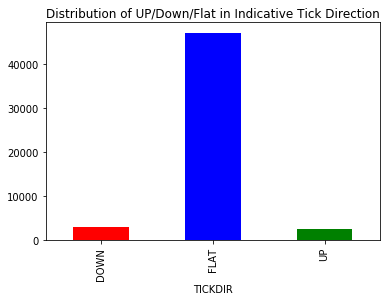

In [10]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [57]:
# extracting a single feature
X0 = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [58]:
X_0 = np.array(X0).reshape(-1,1)

In [59]:
X_0.shape

(52396, 1)

#### Regressing the Bid Ask Imbalance

In [60]:
y0 = inputData.BIDASKIMBALANCE.shift(1)

In [61]:
y = y0.dropna()

In [62]:
y = np.array(y).reshape(-1,1)

In [63]:
y.shape

(52395, 1)

#### Strip initial x values to balance len of x and y

In [66]:
X = X_0[1:]

In [67]:
X.shape

(52395, 1)

#### Reshaping X and Y for ingesting into the model

In [68]:
print("The shape of X is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of X is:  (52395, 1)
The shape of y is:  (52395, 1)


In [69]:
X = X.reshape(X.shape[0],1, X.shape[1])
y = y.reshape(y.shape[0],1, y.shape[1])
print("The shape of x is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of x is:  (52395, 1, 1)
The shape of y is:  (52395, 1, 1)


#### Train test split

In [70]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.10, random_state=0)

#### Sequencing the data

In [71]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [72]:
# define input sequence
in_seq1 = np.array(X_train0)
#in_seq2 = np.array(df_Normal_train.n_0935.values)
out_seq = np.array(y_train0)

In [73]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [74]:
# horizontally stack columns
dataset = np.hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X_train, y_train = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [75]:
y_train.shape

(47146,)

#### Define model

In [77]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])

#### Train model

In [78]:
history = model.fit(X_train, y_train, epochs=3, verbose=1, validation_split = 0.25)

Train on 35359 samples, validate on 11787 samples
Epoch 1/3
35359/35359 [==============================] - 13s 360us/step - loss: 0.0342 - acc: 2.8281e-05 - val_loss: 0.0233 - val_acc: 1.6968e-04
Epoch 2/3
35359/35359 [==============================] - 12s 330us/step - loss: 0.0215 - acc: 2.8281e-05 - val_loss: 0.0258 - val_acc: 1.6968e-04
Epoch 3/3
35359/35359 [==============================] - 12s 331us/step - loss: 0.0210 - acc: 2.8281e-05 - val_loss: 0.0242 - val_acc: 1.6968e-04


#### Plot Loss and Accuracy 

In [79]:
from matplotlib import pyplot

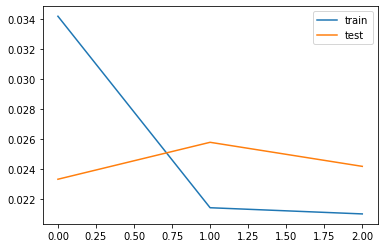

In [80]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

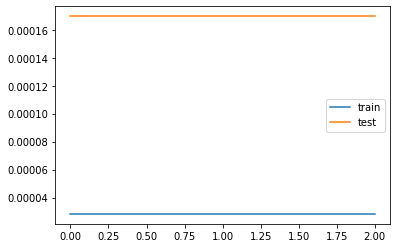

In [81]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

#### Sequencing Testing Data

In [82]:
# define input sequence
in_seq1 = np.array(X_test0)
#in_seq2 = np.array(df_Normal_train.n_0935.values)
out_seq = np.array(y_test0)

In [83]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [84]:
# horizontally stack columns
dataset = np.hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X_test, y_test = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_test.shape[2]

In [85]:
X_test[0]

array([[-0.13855615],
       [ 0.62113482],
       [-0.2177467 ],
       [ 0.68615998],
       [-0.72510472],
       [ 0.91654545],
       [-0.28029044],
       [-0.10808687],
       [ 0.35740959],
       [ 0.77098632]])

In [86]:
X_test[1]

array([[ 0.62113482],
       [-0.2177467 ],
       [ 0.68615998],
       [-0.72510472],
       [ 0.91654545],
       [-0.28029044],
       [-0.10808687],
       [ 0.35740959],
       [ 0.77098632],
       [ 0.10478186]])

#### Make a prediction

In [87]:
yhat = model.predict(X_test)

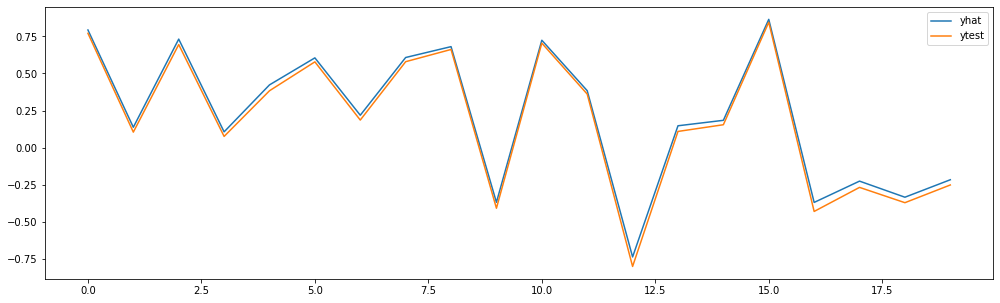

In [98]:
pyplot.figure(figsize=(17,5))
pyplot.plot(yhat[:20], label='yhat')
pyplot.plot(y_test[:20], label='ytest')
pyplot.legend()
pyplot.show()

In [92]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.146


In [93]:
yhat[0]

array([0.7928522], dtype=float32)

In [94]:
y_test[0]

0.7705654000000001

In [95]:
yhat[1]

array([0.13809352], dtype=float32)

In [96]:
y_test[1]

0.10532249

#### Recursive Multi-Step Prediction